# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** This is a classification problem because we're trying to identify if there needs to be an early intervention for a particular student. Students are represented by certain metrics/features that are supposed to represent their graduation potential. These features will help us to decide if "early_intervention_required" is true or not for the given students. To train this classifier we will utilize those features and the labels that represent of the student successfully passed the final exam or not. Trained classifier will be used to predict if an enrolled student has a potential to fail or not in the final exam. If so, early intervention will be required based on the classifiers prediction.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# print student_data.head()
# print len(student_data)
# print student_data.ndim
# print student_data.size
# print student_data.shape

# TODO: Calculate number of students
n_students = student_data.shape[0]

# TODO: Calculate number of features
n_features = student_data.shape[1]-1

# TODO: Calculate passing students
n_passed = student_data[student_data['passed'] == 'yes'].shape[0]

# TODO: Calculate failing students
n_failed = student_data[student_data['passed'] == 'no'].shape[0]

# TODO: Calculate graduation rate
grad_rate = (float(n_passed))/(n_passed+n_failed)*100.0

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

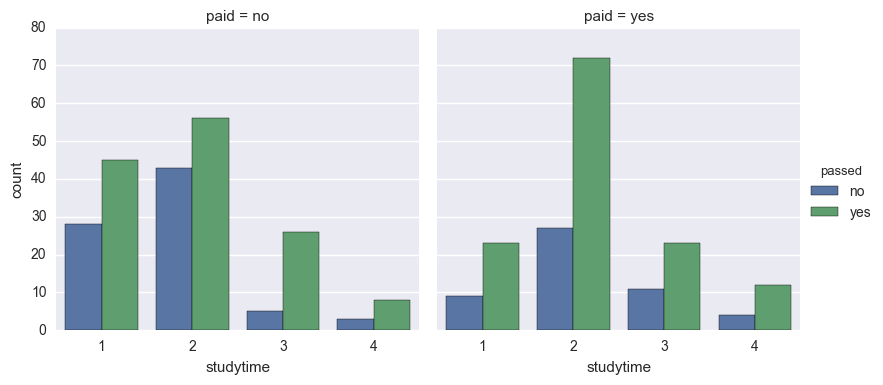

In [3]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

%matplotlib inline
import seaborn as sns
sns.factorplot("studytime", col="paid", data=student_data, hue='passed', kind="count");

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# TODO: Import any additional functionality you may need here

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

test_percent = float(num_test)/X_all.shape[0]

# TODO: Shuffle and split the dataset into the number of training and testing points above
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify=y_all, test_size=test_percent, random_state=42)
print "Train set 'yes' pct = {:.2f}%".format(100 * (y_train == 'yes').mean())
print "Test  set 'yes' pct = {:.2f}%".format(100 * (y_test == 'yes').mean())

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Train set 'yes' pct = 67.00%
Test  set 'yes' pct = 67.37%
Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: ** 
## ENSEMBLE METHODS
Some of the example application areas noted in this survey[1] are Remote Sensing, computer security, financial risk ananlysis, medicine, recommender systems.
#### Reasons for choosing
Among those, recommender systems are particularly interesting for me. They gather information about the online behavior of a user and make estimations based on those to predict the future action of the user/customer. Most of the extracted features are related to the items visited/purchased/engaged with. Labels can be "purchased", "wishlisted", "visited" and so on. Therefore prediction of the future actions/items can be used to recommend the best actions to the user to improve their online shopping experience. This is very similar to the current task of student intervention in terms of (i)the features collected based on the history of similar encounters and (ii)prediction of the possibility of a future event. I found boosting methods more comprehensive than averaging methods as they try to reduce the bias of the added weak classifier rather than taking what is classifies as is. I wanted to see how powerful can it be to combine weak classifiers when it comes to the prediction accuracy.
#### Strenghts
Ability to fuse various learning methods to come up with the best prediction by voting, stacking, bagging and boosting.
#### Weaknesses
Ensemble methods are not guaranteed to perform the best. Its performance depends on the fusion method used. Moreover, ensemble methods may require a larger data set to train all of the learners.

## Stochastic Gradient Descent(SGD)
It is used to minimize an objective function written in the form of sum of differentiable functions. It is the predominant methodology in training deep learning models. It works almost like the ordinary gradient descent, but quicker by estimating the gradient based on few examples (most of the time randomly picked one example) at a time instead of the entire training set like the gradient descent does.
#### Reasons for choosing
A simple and quick method. Nice to see it against other more complicated methods.
#### Strenghts
SGD converges fast and allows incorporation of newly captured samples in a more real-time fashion.
#### Weaknesses
However, it requires manual tuning of the optimization parameters such as learning rates and convergence criteria[2]. This usually requires domain knowledge. In that case, learning algorithm is run with many optimization parameters and pick the model that gives the best performance on a validation set. Therefore this goes against its fast convergence advantage. Moreover, it is inherently sequential. Therefore, hard to parallelize using GPUs or computer clusters. Therefore, if given enough computation power, this algorithm cannot harness all of it.

## K-Nearest Neighbor (KNeighbors)
A type of instance-based learning, or lazy learning. In other words the classification function is only approximated in locality of k instances. 
#### Strenghts
It is fast if data is stored in a sorted fashion. There is no training time whatsoever. The label of the query sample is assigned based on the majority voting of the k neighbors. Nothing is computed till the query is done. 
#### Weaknesses
However, majority voting results in biased predictions based on the skewed data distribution. In other words, if one of the classes dominates others, it is more likely that there will be more of that class in k-neighborhood. Another problem is that the distance measurement is affected by the distance metric used for different features[3]. For instance, milage of a car can easily outweigh the color of a car when these are used as two main features to represent an old or new car for instance. there might be 100 different colors, but the milage can differ maybe at the levels of 100s of thousands of miles. Therefore, weighing of these features needs to be adjusted while measuring the distance between different instances.
#### Reasons for choosing
A baseline method to compare against other methods.

[1] Woźniak, Michał, Manuel Graña, and Emilio Corchado. "A survey of multiple classifier systems as hybrid systems." Information Fusion 16 (2014): 3-17.

[2] Ngiam, Jiquan, et al. "On optimization methods for deep learning." Proceedings of the 28th International Conference on Machine Learning (ICML-11). 2011.

[3] Weinberger, Kilian Q., John Blitzer, and Lawrence K. Saul. "Distance metric learning for large margin nearest neighbor classification." Advances in neural information processing systems. 2005.

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [6]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [10]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

# TODO: Initialize the three models
# clf_A = SGDClassifier(loss="hinge", penalty="l2")
clf_A = SGDClassifier()
# clf_B = AdaBoostClassifier(n_estimators=100)
clf_B = AdaBoostClassifier()
# clf_C = KNeighborsClassifier(15, weights='distance')
clf_C = KNeighborsClassifier()

# TODO: Set up the training set sizes
X_train, X_test, y_train, y_test

X_train_100 = X_train[0:100]
y_train_100 = y_train[0:100]

X_train_200 = X_train[0:200]
y_train_200 = y_train[0:200]

X_train_300 = X_train[0:300]
y_train_300 = y_train[0:300]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
clfs = {clf_A, clf_B, clf_C}
for clf in clfs:
    train_predict(clf, X_train_100, y_train_100, X_test, y_test)
    train_predict(clf, X_train_200, y_train_200, X_test, y_test)
    train_predict(clf, X_train_300, y_train_300, X_test, y_test)

Training a AdaBoostClassifier using a training set size of 100. . .
Trained model in 0.1340 seconds
Made predictions in 0.0080 seconds.
F1 score for training set: 0.9778.
Made predictions in 0.0070 seconds.
F1 score for test set: 0.6880.
Training a AdaBoostClassifier using a training set size of 200. . .
Trained model in 0.1370 seconds
Made predictions in 0.0090 seconds.
F1 score for training set: 0.8905.
Made predictions in 0.0080 seconds.
F1 score for test set: 0.7445.
Training a AdaBoostClassifier using a training set size of 300. . .
Trained model in 0.1420 seconds
Made predictions in 0.0100 seconds.
F1 score for training set: 0.8565.
Made predictions in 0.0110 seconds.
F1 score for test set: 0.7328.
Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0020 seconds.
F1 score for training set: 0.8252.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.7586.
Training a KNeighborsClassifier using a traini

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - SGDClassifier **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0000           |        0.0000          |      0.8153      |      0.7947     |
| 200               |        0.0010           |        0.0000          |      0.7950      |      0.8052     |
| 300               |        0.0010           |        0.0000          |      0.8180      |      0.7838     |

** Classifer 2 - AdaBoostClassifier **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.1290           |         0.0070         |      0.9778      |       0.6880    |
| 200               |        0.1360           |         0.0080         |      0.8905      |       0.7445    |
| 300               |        0.1400           |         0.0080         |      0.8565      |       0.7328    |

** Classifer 3 - KNeighborsClassifier **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0010           |         0.0020         |       0.8252     |     0.7586      |
| 200               |        0.0010           |         0.0040         |       0.8097     |     0.7857      |
| 300               |        0.0010           |         0.0050         |       0.8539     |     0.8138      |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** 
#### [OLD ANSWER]
I would choose SGDClassifier since it has a monotonically increasing trend in getting better F1 scores based on the test data. Although KNeighborsClassifier seems to be better in the overall result, it's performance is decreasing after 200 samples in the training set. Hence, if we collect and train our prediction model with a larger data set, SGDClassifier seems to perform better than the others. SGDClassifier's training and testing times are also better than the other classifier.
#### [UPDATED ANSWER]
Every time I run this experiment I've got different results, especually the F1 test scores varied a lot. KNeighbors seems to be performing as good as SGDClassifer and its performance is increasing with the increasing training set size. I think this is more important than other metrics because this means that the classifier might be learning better every time it sees a new sample. Therefore, it will perform better and better in time. But it is definitely not Adaboost as its training and testing performance degrades with the increasing training data set size in terms of training time and training and testing f1 scores.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** SGDClassifier decides on the most distinctive seperation rule that helps classifying students into two distinct categories so much so that according to the learned rule, the similarity between two students from different classes is highly minimized. It finds a way to combine the given measured qualifities of the students so that the students who passed the exam are very similar to each other, just like the students who failed at the exam are very similar to each other. Moreover, it finds this rule so fast as it considers every single student while improvizing its decision criteria rather than looking them all every single time when it couldn't get it right. It just improves one student at a time, does its best with what it knows at that moment. To predict if a new student is likely to graduate, it only asks the learned rule without comparing that student with others students. Therefore, it decides fast when it is asked about a new student.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [36]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

# TODO: Create the parameters list you wish to tune
parameters = {'loss': ['hinge', 'modified_huber', 'log'], 'penalty': ['l1', 'l2', 'elasticnet']}

# TODO: Initialize the classifier
from sklearn.linear_model import SGDClassifier
# clf = SGDClassifier(loss="hinge", penalty=parameters['penalty'])
# clf = SGDClassifier(loss='hinge', penalty='l2')
clf = SGDClassifier()

from sklearn.metrics import f1_score

# def performance_metric(y_true, y_predict):
#     """ Calculates and returns the performance score between 
#         true and predicted values based on the metric chosen. """
    
#     # TODO: Calculate the performance score between 'y_true' and 'y_predict'
#     score = f1_score(y_true, y_predict)
    
#     # Return the score
#     return score

# TODO: Make an f1 scoring function using 'make_scorer' 
# f1_scorer = make_scorer(performance_metric, pos_label="yes")
f1_scorer = make_scorer(f1_score, pos_label="yes")

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=f1_scorer)
# grid_obj = GridSearchCV(clf, param_grid=dict(penalty=parameters), scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)
# grid_obj = grid_obj.fit(X_train_300, y_train_300)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train_300, y_train_300))
# print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

from sklearn.preprocessing import normalize
X_train = normalize(X_train)
X_test = normalize(X_test)

# The default grid search uses 3 folds; use the 'cv' param to change this
grid_obj = GridSearchCV(clf, parameters, cv=5,
                        scoring=f1_scorer, verbose=1,
                        n_jobs=-1, pre_dispatch='2*n_jobs')

grid_obj = grid_obj.fit(X_train, y_train)
clf = grid_obj.best_estimator_

print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train_300, y_train_300))
# print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0010 seconds.
Tuned model has a training F1 score of 0.8024.
Made predictions in 0.0000 seconds.
Tuned model has a testing F1 score of 0.7838.
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Made predictions in 0.0010 seconds.
Tuned model has a training F1 score of 0.8147.
Made predictions in 0.0000 seconds.
Tuned model has a testing F1 score of 0.7801.


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.7s finished


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** Tuned model has a slightly better performance in training [0.8180 <-> 0.8403] and testing [0.7838 <-> 0.8054]. Yet, these parameters do not seem to make huge difference in training and testing performance. Default parameter settings seem to be working well for this particular dataset and for SGDClassifier. This might be because of the small data size size. Since data set is small, it may effect the performance of the training and testing considerably depending on how data set is split. Every time I run the experiment, I get different results. I also tried to increase the number of folds in the grid search and normalize the features, results didn't change much for the SGDClassifier. I believe normalizing the features doesn't effect the performance of the gradient descent as it considers the rate of change other than unit or magnitude of features.



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.